In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [9]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [11]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [12]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [13]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [14]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [15]:
class RecDecoderHead(nn.Module):
    def __init__(self):
        super(RecDecoderHead, self).__init__()
        self.fc = nn.Linear(1, 128)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderBody(nn.Module):
    def __init__(self):
        super(RecDecoderBody, self).__init__()
        self.fc = nn.Linear(129, 128) # prev state + hidden
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderTail(nn.Module):  
    def __init__(self):
        super(RecDecoderTail, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)      
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        o = h3.view(-1,784)
        return F.sigmoid(o)    

In [16]:
E = Encoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]
D_head = RecDecoderHead()
D_body = [RecDecoderBody() for _ in range(N-1)]
D_tail = RecDecoderTail()

In [17]:
if CUDA:
    E.cuda()
    O0.cuda()
    [e.cuda() for e in Os]
    [e.cuda() for e in Ts]
    [e.cuda() for e in T1s]
    [e.cuda() for e in Gs]
    D_head.cuda()
    [e.cuda() for e in D_body]
    D_tail.cuda()

In [18]:
import os
os.system('mkdir -p checkpoint_recdecoder_receverystep')
PATH = 'checkpoint_recdecoder_receverystep/hd_vae'
def save_model():
    torch.save(E.state_dict(), "{}_E".format(PATH))
    torch.save(O0.state_dict(), "{}_O0".format(PATH))
    
    def save_list(models, name):
        for i in range(len(models)):
            torch.save(models[i].state_dict(), "{}_{}_{}".format(PATH, name, i))
    
    save_list(Os, 'Os')
    save_list(Ts, 'Ts')
    save_list(T1s, 'T1s')
    save_list(Gs, 'Gs')
    
    torch.save(D_head.state_dict(), "{}_D_head".format(PATH))
    save_list(D_body, 'D_body')
    torch.save(D_tail.state_dict(), "{}_D_tail".format(PATH))
    
#save_model()

In [46]:
def prob(outputs, N=N, k=k):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

In [54]:
from itertools import product
    
log_two_pow_ns = []

for n in range(N+1):
    log_two_pow_n = Variable(torch.Tensor([2**n]).log(), requires_grad=False)
    if CUDA:
        log_two_pow_n = log_two_pow_n.cuda()
    log_two_pow_ns.append(log_two_pow_n)

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    
    batch_size = x.shape[0]
    
    def get_kl(q, path, n, batch_size):
        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([batch_size]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_ns[n] + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch
        return kl_term
    
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
            
        kl_term = 0
        
        sofar = E(x)
        outputs = [O0(sofar)]

        nn = len(outputs)
        q = prob(outputs, nn)
        kl_term += get_kl(q, path[:nn], nn, batch_size)
        
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](path[n]) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))

            nn = len(outputs)
            q = prob(outputs, nn)
            kl_term += get_kl(q, path[:nn], nn, batch_size)

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [55]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
 20.8093
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [56]:
# TODO
# objective
def loss_function(recons, x, q):
    _bsize = x.shape[0]
    BCES = [F.binary_cross_entropy(recon_x, x, size_average=False)/_bsize for recon_x in recons]
    BCE = sum(BCES)
    
    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x) # this sums together the KLD
    return BCE, KLD

In [57]:
params = [
    {'params':E.parameters()},
    {'params':O0.parameters()} 
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] \
  + [{'params': g.parameters()} for g in Gs] \
  + [{'params': D_head.parameters()}, {'params': D_tail.parameters()}] \
  + [{'params': d_body.parameters()} for d_body in D_body]
optimizer = optim.Adam(params, lr=1e-4)

In [58]:
best_loss_sofar = 9999

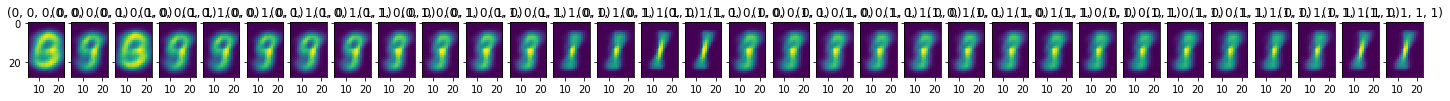

In [59]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        t = t.unsqueeze(0)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        decoder_hidden = D_head(make_variable(path[0]))
        for n in range(1, len(path)):
            decoder_hidden_inp = torch.cat([decoder_hidden, make_variable(path[n])], -1)
            decoder_hidden = D_body[n-1](decoder_hidden_inp)
        w = D_tail(decoder_hidden)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [60]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        decoder_hidden = D_head(samples[-1])
        recons = [D_tail(decoder_hidden)]
        # TODO unroll this may make it faster
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
            
            decoder_hidden_inp = torch.cat([decoder_hidden, samples[-1]], -1)
            decoder_hidden = D_body[n](decoder_hidden_inp)
            recons.append(D_tail(decoder_hidden))
            
#         recon_x = D_tail(decoder_hidden)
     
        bits = torch.cat(samples, dim=1) # for debugging only
        q = prob(outputs)

        BCE, KLD = loss_function(recons, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        save_model()
        best_loss_sofar = avg_loss
        debug()
        
    return q, bits # debugging

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 9.701730	KLD loss: 0.183287
Train Epoch: 1 [20000/60000 (33%)]	BCE loss: 9.972094	KLD loss: 0.115078
Train Epoch: 1 [40000/60000 (67%)]	BCE loss: 9.494227	KLD loss: 0.109802
====> Epoch: 1 Average BCE loss: 9.7722, Average KLD loss: 0.1210, Total: 9.8933
Loss 9.89325053636233 is better than previous best 9999, saving model


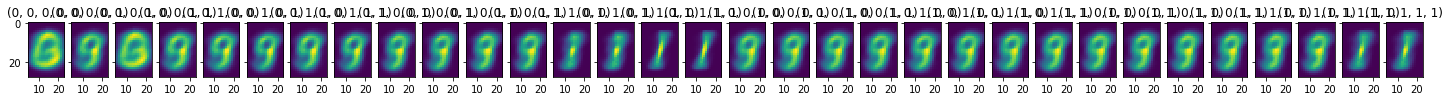

Train Epoch: 2 [0/60000 (0%)]	BCE loss: 9.550048	KLD loss: 0.103024
Train Epoch: 2 [20000/60000 (33%)]	BCE loss: 9.498687	KLD loss: 0.104810
Train Epoch: 2 [40000/60000 (67%)]	BCE loss: 9.568147	KLD loss: 0.095750
====> Epoch: 2 Average BCE loss: 9.7834, Average KLD loss: 0.1059, Total: 9.8894
Loss 9.88935473443667 is better than previous best 9.89325053636233, saving model


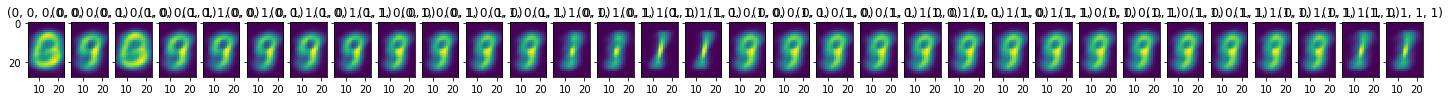

Train Epoch: 3 [0/60000 (0%)]	BCE loss: 9.588478	KLD loss: 0.106541
Train Epoch: 3 [20000/60000 (33%)]	BCE loss: 9.720919	KLD loss: 0.105025
Train Epoch: 3 [40000/60000 (67%)]	BCE loss: 9.291381	KLD loss: 0.114979
====> Epoch: 3 Average BCE loss: 9.7885, Average KLD loss: 0.1107, Total: 9.8992
Train Epoch: 4 [0/60000 (0%)]	BCE loss: 9.559812	KLD loss: 0.138660
Train Epoch: 4 [20000/60000 (33%)]	BCE loss: 9.656797	KLD loss: 0.136195
Train Epoch: 4 [40000/60000 (67%)]	BCE loss: 9.500105	KLD loss: 0.117773
====> Epoch: 4 Average BCE loss: 9.7837, Average KLD loss: 0.1347, Total: 9.9185
Train Epoch: 5 [0/60000 (0%)]	BCE loss: 10.037061	KLD loss: 0.147840
Train Epoch: 5 [20000/60000 (33%)]	BCE loss: 9.952051	KLD loss: 0.139455
Train Epoch: 5 [40000/60000 (67%)]	BCE loss: 9.734709	KLD loss: 0.149919
====> Epoch: 5 Average BCE loss: 9.7903, Average KLD loss: 0.1415, Total: 9.9318
Train Epoch: 6 [0/60000 (0%)]	BCE loss: 10.103967	KLD loss: 0.148485
Train Epoch: 6 [20000/60000 (33%)]	BCE loss: 

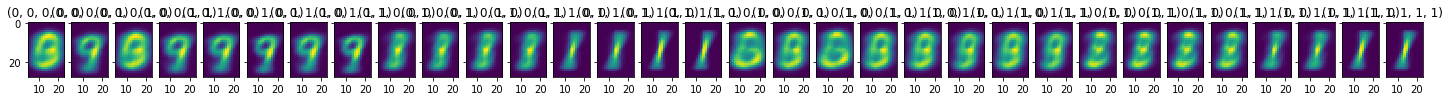

Train Epoch: 10 [0/60000 (0%)]	BCE loss: 9.775266	KLD loss: 0.147102
Train Epoch: 10 [20000/60000 (33%)]	BCE loss: 10.081411	KLD loss: 0.152404
Train Epoch: 10 [40000/60000 (67%)]	BCE loss: 9.572296	KLD loss: 0.157371
====> Epoch: 10 Average BCE loss: 9.7139, Average KLD loss: 0.1495, Total: 9.8634
Loss 9.863371272118886 is better than previous best 9.877310604604084, saving model


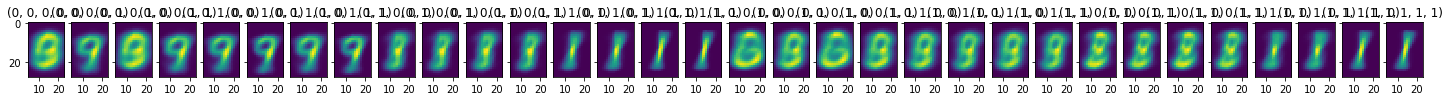

Train Epoch: 11 [0/60000 (0%)]	BCE loss: 9.589393	KLD loss: 0.141761
Train Epoch: 11 [20000/60000 (33%)]	BCE loss: 9.583837	KLD loss: 0.153129
Train Epoch: 11 [40000/60000 (67%)]	BCE loss: 10.111678	KLD loss: 0.157744
====> Epoch: 11 Average BCE loss: 9.7092, Average KLD loss: 0.1489, Total: 9.8581
Loss 9.85809030950864 is better than previous best 9.863371272118886, saving model


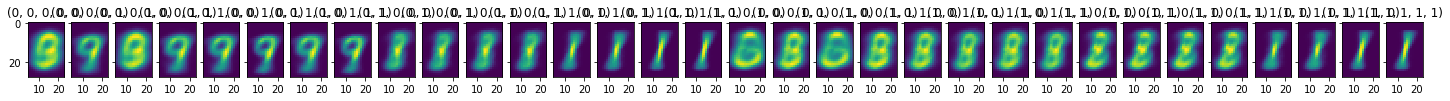

Train Epoch: 12 [0/60000 (0%)]	BCE loss: 9.561063	KLD loss: 0.147420
Train Epoch: 12 [20000/60000 (33%)]	BCE loss: 9.673300	KLD loss: 0.145011
Train Epoch: 12 [40000/60000 (67%)]	BCE loss: 9.735968	KLD loss: 0.161453
====> Epoch: 12 Average BCE loss: 9.7084, Average KLD loss: 0.1499, Total: 9.8583
Train Epoch: 13 [0/60000 (0%)]	BCE loss: 9.595230	KLD loss: 0.160279
Train Epoch: 13 [20000/60000 (33%)]	BCE loss: 9.529006	KLD loss: 0.143326
Train Epoch: 13 [40000/60000 (67%)]	BCE loss: 9.590880	KLD loss: 0.149792
====> Epoch: 13 Average BCE loss: 9.7057, Average KLD loss: 0.1511, Total: 9.8568
Loss 9.856793040100733 is better than previous best 9.85809030950864, saving model


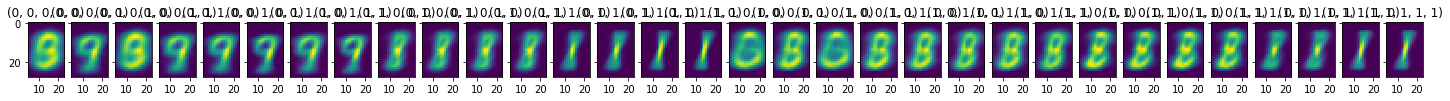

Train Epoch: 14 [0/60000 (0%)]	BCE loss: 9.806710	KLD loss: 0.148482
Train Epoch: 14 [20000/60000 (33%)]	BCE loss: 9.709595	KLD loss: 0.154317
Train Epoch: 14 [40000/60000 (67%)]	BCE loss: 9.806454	KLD loss: 0.132219
====> Epoch: 14 Average BCE loss: 9.7088, Average KLD loss: 0.1509, Total: 9.8598
Train Epoch: 15 [0/60000 (0%)]	BCE loss: 9.803685	KLD loss: 0.154767
Train Epoch: 15 [20000/60000 (33%)]	BCE loss: 10.071437	KLD loss: 0.145320
Train Epoch: 15 [40000/60000 (67%)]	BCE loss: 9.481577	KLD loss: 0.144276
====> Epoch: 15 Average BCE loss: 9.7148, Average KLD loss: 0.1516, Total: 9.8664
Train Epoch: 16 [0/60000 (0%)]	BCE loss: 9.931063	KLD loss: 0.148556
Train Epoch: 16 [20000/60000 (33%)]	BCE loss: 9.538167	KLD loss: 0.148103
Train Epoch: 16 [40000/60000 (67%)]	BCE loss: 9.528749	KLD loss: 0.159160
====> Epoch: 16 Average BCE loss: 9.7102, Average KLD loss: 0.1503, Total: 9.8605
Train Epoch: 17 [0/60000 (0%)]	BCE loss: 9.585227	KLD loss: 0.146798
Train Epoch: 17 [20000/60000 (33%

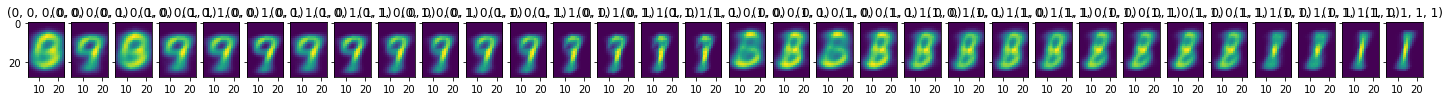

Train Epoch: 19 [0/60000 (0%)]	BCE loss: 9.490521	KLD loss: 0.209235
Train Epoch: 19 [20000/60000 (33%)]	BCE loss: 9.497889	KLD loss: 0.193889
Train Epoch: 19 [40000/60000 (67%)]	BCE loss: 9.899443	KLD loss: 0.187207
====> Epoch: 19 Average BCE loss: 9.5459, Average KLD loss: 0.1978, Total: 9.7437
Loss 9.743678588930765 is better than previous best 9.766153640508652, saving model


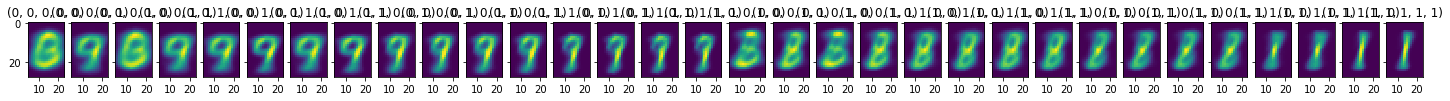

Train Epoch: 20 [0/60000 (0%)]	BCE loss: 9.508958	KLD loss: 0.204131
Train Epoch: 20 [20000/60000 (33%)]	BCE loss: 9.364779	KLD loss: 0.190034
Train Epoch: 20 [40000/60000 (67%)]	BCE loss: 9.961880	KLD loss: 0.188939
====> Epoch: 20 Average BCE loss: 9.5444, Average KLD loss: 0.1906, Total: 9.7349
Loss 9.734916605695089 is better than previous best 9.743678588930765, saving model


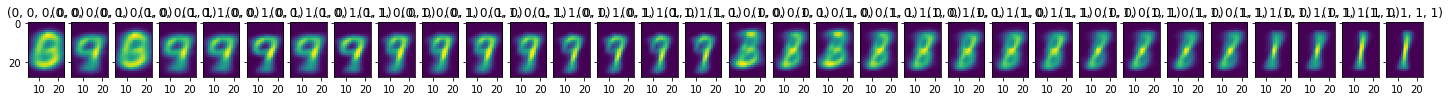

Train Epoch: 21 [0/60000 (0%)]	BCE loss: 9.218076	KLD loss: 0.195709
Train Epoch: 21 [20000/60000 (33%)]	BCE loss: 9.598494	KLD loss: 0.180852
Train Epoch: 21 [40000/60000 (67%)]	BCE loss: 9.227225	KLD loss: 0.191463
====> Epoch: 21 Average BCE loss: 9.5505, Average KLD loss: 0.1907, Total: 9.7411
Train Epoch: 22 [0/60000 (0%)]	BCE loss: 9.702988	KLD loss: 0.185989
Train Epoch: 22 [20000/60000 (33%)]	BCE loss: 9.699856	KLD loss: 0.182159
Train Epoch: 22 [40000/60000 (67%)]	BCE loss: 9.203022	KLD loss: 0.199280
====> Epoch: 22 Average BCE loss: 9.5555, Average KLD loss: 0.1929, Total: 9.7484
Train Epoch: 23 [0/60000 (0%)]	BCE loss: 9.227747	KLD loss: 0.208091
Train Epoch: 23 [20000/60000 (33%)]	BCE loss: 9.264049	KLD loss: 0.194567
Train Epoch: 23 [40000/60000 (67%)]	BCE loss: 9.844423	KLD loss: 0.199153
====> Epoch: 23 Average BCE loss: 9.5707, Average KLD loss: 0.1945, Total: 9.7652
Train Epoch: 24 [0/60000 (0%)]	BCE loss: 9.886880	KLD loss: 0.187411
Train Epoch: 24 [20000/60000 (33%)

In [ ]:
%%time
for epoch in range(100):
    q, bits = train(epoch)

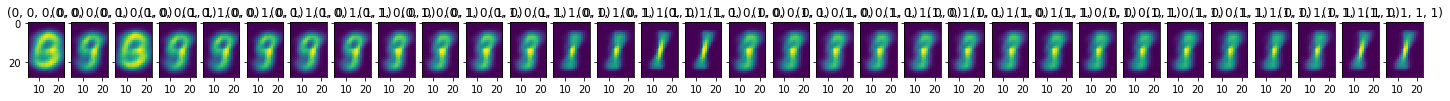

In [36]:
debug()

In [28]:
q

Variable containing:
( 0 ,.,.) = 
  1.0000e+00  2.9886e-11
  4.5691e-04  9.9954e-01
  9.9990e-01  9.8258e-05
  4.7400e-08  1.0000e+00
  4.4518e-01  5.5482e-01

( 1 ,.,.) = 
  1.0000e+00  8.8651e-14
  1.6217e-03  9.9838e-01
  9.9999e-01  5.2026e-06
  1.3970e-08  1.0000e+00
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  1.0000e+00  6.3210e-08
  1.5300e-03  9.9847e-01
  9.0505e-01  9.4953e-02
  2.9849e-05  9.9997e-01
  5.0000e-01  5.0000e-01
... 

(97 ,.,.) = 
  1.0000e+00  9.2222e-16
  3.7653e-07  1.0000e+00
  5.0000e-01  5.0000e-01
  7.7240e-11  1.0000e+00
  2.8021e-03  9.9720e-01

(98 ,.,.) = 
  2.1245e-01  7.8755e-01
  5.8848e-01  4.1152e-01
  9.9948e-01  5.2490e-04
  3.7940e-04  9.9962e-01
  1.0150e-02  9.8985e-01

(99 ,.,.) = 
  1.0000e+00  1.6481e-17
  5.1857e-06  9.9999e-01
  1.0000e+00  5.3553e-07
  2.6385e-16  1.0000e+00
  2.8627e-05  9.9997e-01
[torch.cuda.FloatTensor of size 100x5x2 (GPU 0)]

In [29]:
bits

Variable containing:
    1     0     1     0     0
    1     0     1     0     1
    1     0     1     0     1
    1     0     0     1     0
    1     0     1     0     1
    1     0     0     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     1
    1     0     1     0     1
    1     0     0     0     1
    1     0     0     0     0
    1     0     0     0     1
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     1     0     0
    1     0     0     0     0
    1     0     1     0     0
    1     0     1  